In [1]:
import numpy as np
import keras
from keras.models import Sequential 
from keras.layers import Activation 
from keras.layers.core import Dense, Flatten 
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization 
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix 
import itertools
import matplotlib.pyplot as plt
%matplotlib inline 

Using TensorFlow backend.


# Variables that are paths to the specified categories: train, valid, and test

In [2]:
train_path = 'components/train'
valid_path = 'components/valid'
test_path = 'components/test'

# Variables that holds a function to call upon the pictures in the different classes: power, resistor, and null. 

(resized images to 244, by 244 pixel)
(batch size indicates how many pictures are grabbed at 1 time) 

In [3]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224),classes=['power','resistor', 'null'], batch_size=10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224),classes=['power', 'resistor', 'null' ], batch_size=10)


Found 60 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


# Function to plot the components with specified binary values 

In [4]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None ):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range (len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

In [5]:
imgs, labels = next(train_batches)

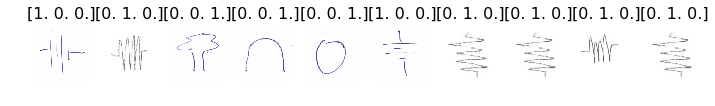

In [6]:
plots(imgs, titles=labels)

# MODEL2 - VGG16 From Keras Applications 

In [7]:
vgg16_model = keras.applications.vgg16.VGG16() 
#downloads vgg16 model from keras aplications 


In [8]:
#creates a model named 'model' that is of Sequential form , VGG16 is in a non-sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]:  # deletes last layer of VGG16 as VGG16 pertains to 1000 classes, we have 3 
    model.add(layer) # add  a layer back to the bottom 
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [9]:
for layer in model.layers:
    layer.trainable = False

In [10]:
model.add(Dense(3, activation='softmax'))  # add a dense 3 output layer, we have 3 classes 

In [11]:
model.compile(Adam(lr=.0001), loss = 'categorical_crossentropy', metrics=['accuracy']) # compile model 

In [12]:
#train the model , 60 training and valid images so  10 epochs with 6 steps = 60, 

model.fit_generator(train_batches, steps_per_epoch=6, validation_data=valid_batches, validation_steps=6, epochs=10, verbose=2)

Epoch 1/10
 - 57s - loss: 2.3577 - acc: 0.3500 - val_loss: 1.7407 - val_acc: 0.4000
Epoch 2/10
 - 58s - loss: 1.4569 - acc: 0.4000 - val_loss: 1.0392 - val_acc: 0.4333
Epoch 3/10
 - 58s - loss: 0.8778 - acc: 0.5833 - val_loss: 0.6258 - val_acc: 0.7833
Epoch 4/10
 - 58s - loss: 0.5448 - acc: 0.8167 - val_loss: 0.3928 - val_acc: 0.9000
Epoch 5/10
 - 59s - loss: 0.3561 - acc: 0.9000 - val_loss: 0.2592 - val_acc: 0.9500
Epoch 6/10
 - 59s - loss: 0.2351 - acc: 0.9500 - val_loss: 0.1882 - val_acc: 0.9500
Epoch 7/10
 - 58s - loss: 0.1806 - acc: 0.9500 - val_loss: 0.1431 - val_acc: 0.9500
Epoch 8/10
 - 58s - loss: 0.1371 - acc: 0.9500 - val_loss: 0.1123 - val_acc: 0.9500
Epoch 9/10
 - 57s - loss: 0.1062 - acc: 0.9500 - val_loss: 0.0915 - val_acc: 0.9667
Epoch 10/10
 - 57s - loss: 0.0873 - acc: 1.0000 - val_loss: 0.0758 - val_acc: 1.0000


# Testing Model No.2 :VGG16

# Run cell below for testing

Found 36 images belonging to 3 classes.
raw prediction values: [[0.014 0.02  0.966]]
[0.966] % CONFIDENT, NULL


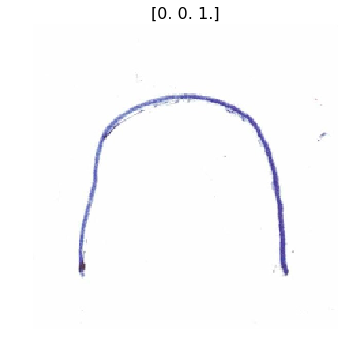

In [32]:

#plot a batch of test images with corresponding binary values 
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224),classes=['power', 'resistor', 'null' ], batch_size=1)
test_imgs, test_labels = next(test_batches)
#plots(test_imgs, titles=test_labels)


#predictions of the tested symbols 
predictions = model.predict_generator(test_batches, steps=1, verbose=2)

plots(test_imgs,titles=test_labels)



predictions = np.around(predictions,3)
print ( "raw prediction values:", predictions)



z = np.delete(predictions, [0,1])
y = np.delete(predictions, [0,2])
x = np.delete(predictions, [1,2])

if (x>y and x >z):    
    print(x,"% CONFIDENT, POWER SOURCE")
if (y >x and y>z):
    print(y,"% CONFIDENT, RESISTOR")
if (z> y and z >x):
    print(z, "% CONFIDENT, NULL")
